# Part 1 - Data Gathering

FIDE doesn't provide a unified database with player ratings over the years. Therefore, this first part of the notebook is to assemble this base.

At the end of this process, a file named `ratings.json` will be generated, with the top-100 players over the years.  
The structure of this file is show bellow:

```python
[
    # ...
    {
        'date_human': 'January 2018',
        'year': 2018,
        'month': 'January',
        'ratings': [
            ['Carlsen, Magnus', 2834],
            ['Caruana, Fabiano', 2811],
            # ...
        ]
    },
    # ...
]
```

This process **doesn't** need to be executed. The `ratings.json` file is available in this repository.  
The code below is here for historical reasons.

In [1]:
# import json
# import requests
# from bs4 import BeautifulSoup

# URL_TEMPLATE = "https://ratings.fide.com/toparc.phtml?cod={{ cod }}"
# COD_START = 1 # july-2000

# rankings = []

# cod = COD_START
# while True:
#     url = URL_TEMPLATE.replace('{{ cod }}', str(cod))
#     print(f"Downloading ranking from {url}")

#     r = requests.get(url)
#     if r.status_code != 200:
#         print(f"[ERROR] Couldn't download this ranking. Status code: {r.status_code}")
#         continue

#     soup = BeautifulSoup(r.content, 'html.parser')

#     title = soup.title.text
#     if 'Top 100' not in title:
#         # We reached the last ranking :)
#         break

#     date_human = title.split('Top 100 Players ')[1].split(' FIDE')[0]
#     year, month = date_human.split(' ')

#     ratings = []
#     table = soup.find(id='main-col').find_all('table')[1].find('table')
#     for row in table.find_all('tr'):
#         cols = row.find_all('td')
#         player_name = cols[1].text.strip()
#         if player_name == 'Name':
#             continue

#         rating = int(cols[4].text.strip())
#         ratings.append([player_name, rating])

#     # FIDE has 4 rankings: open, women, juniors and girls.
#     # For now, we're only interested in open. Therefore, in each iteration we increment the `cod` in 4.
#     cod += 4

#     rankings.append({
#         'date_human': date_human,
#         'year': year,
#         'month': int(month),
#         'ratings': ratings,
#     })
    
# with open('./ratings.json', 'w') as fp:
#     json.dump(rankings, fp)

# print('Done!')

# Part 2

Some analysis comparing the top-1 rating with other ones, considering:
- some percentiles of player's ratings;
- the average of player's ratings;
- the rating of top-2;

The main goal here is to understand how far the top-1 was in relation to the others.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Set figsize for all graphs
plt.rcParams['figure.figsize'] = [20, 10]

ratings_df = pd.read_json('ratings.json')
ratings_df

,date_human,year,month,ratings
0,July 2000,July,2000,"[[Kasparov, Garry, 2849], [Kramnik, Vladimir, ..."
1,October 2000,October,2000,"[[Kasparov, Garry, 2849], [Anand, Viswanathan,..."
2,January 2001,January,2001,"[[Kasparov, Gary, 2849], [Anand, Viswanathan, ..."
3,April 2001,April,2001,"[[Kasparov, Garry, 2827], [Kramnik, Vladimir, ..."
4,July 2001,July,2001,"[[Kasparov, Garry, 2838], [Kramnik, Vladimir, ..."
...,...,...,...,...
186,July 2023,July,2023,"[[Carlsen, Magnus, 2835], [Nakamura, Hikaru, 2..."
187,August 2023,August,2023,"[[Carlsen, Magnus, 2835], [Nakamura, Hikaru, 2..."
188,September 2023,September,2023,"[[Carlsen, Magnus, 2839], [Caruana, Fabiano, 2..."
189,October 2023,October,2023,"[[Carlsen, Magnus, 2839], [Caruana, Fabiano, 2..."


In [3]:
data = []

for index, row in ratings_df.iterrows():
    all_ratings = [r[1] for r in row['ratings']]
    all_ratings = np.array(all_ratings)

    top_1 = all_ratings[0]
    top_2 = all_ratings[1]
    top_3 = all_ratings[2]

    data.append({
        'date_human': row['date_human'],
        'p50': np.percentile(all_ratings, 50),
        'p75': np.percentile(all_ratings, 75),
        'p95': np.percentile(all_ratings, 95),
        'avg': np.average(all_ratings),
        'top_1': top_1,
        'top_2': top_2,
        'top_3': top_3,
    })

df = pd.DataFrame(data)
df

,date_human,p50,p75,p95,avg,top_1,top_2,top_3
0,July 2000,2631.5,2666.25,2746.45,2643.55,2849,2770,2762
1,October 2000,2630.5,2665.25,2746.10,2643.58,2849,2774,2772
2,January 2001,2636.5,2671.25,2745.00,2646.67,2849,2790,2772
3,April 2001,2634.0,2670.25,2731.90,2646.09,2827,2802,2794
4,July 2001,2630.0,2669.25,2731.40,2645.04,2838,2802,2797
...,...,...,...,...,...,...,...,...
186,July 2023,2688.5,2719.25,2777.10,2695.57,2835,2787,2782
187,August 2023,2684.5,2717.00,2777.10,2694.28,2835,2787,2782
188,September 2023,2688.0,2717.50,2771.30,2694.00,2839,2786,2780
189,October 2023,2687.5,2716.25,2771.30,2693.63,2839,2786,2780


In [4]:
GRAPH_LINES_COLORS = {
    'p50': 'cyan',
    'p75': 'blue',
    'p95': 'pink',
    'avg': 'brown',
    'top_1': 'red',
    'top_2': 'green',
    'top_3': 'yellow',
}

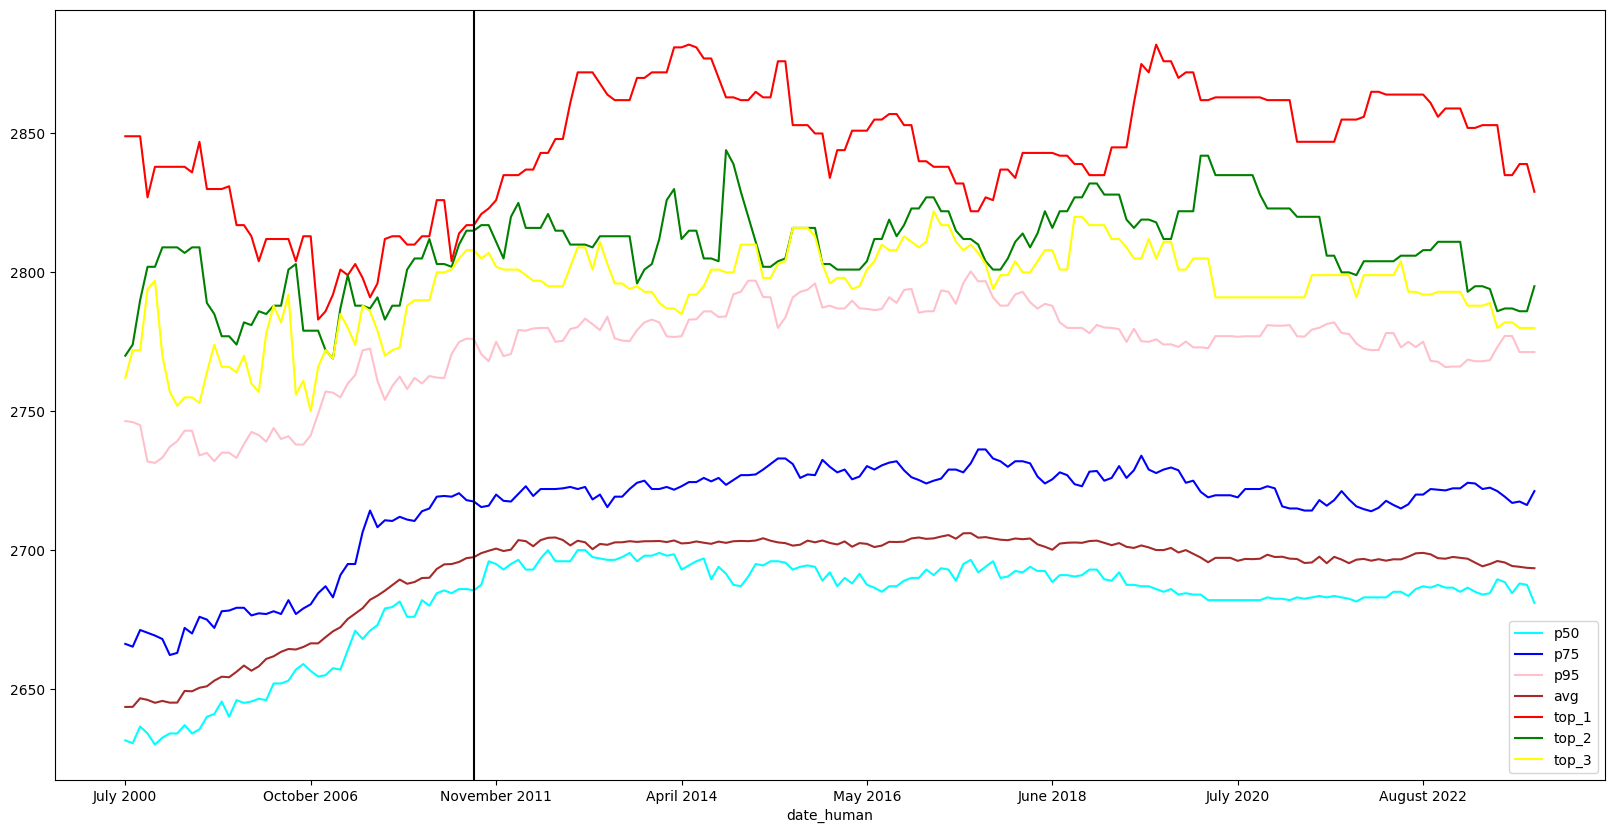

In [5]:
ax = plt.gca()

for col_name in df.columns:
    if col_name == 'date_human':
        continue
    df.plot(kind='line', x='date_human', y=col_name, color=GRAPH_LINES_COLORS[col_name], ax=ax)

magnus_vline_index = df[df['date_human'] == 'May 2011'].index[0]
plt.axvline(x=magnus_vline_index, color='black')
  
plt.show()

## Note

The vertical line in the graph above shows the moment when Magnus Carlsen became the top-1 player in the world.

The graph also shows there was some kind of inflation in ratings until ~nov/2011.  
Since then, the p50, p75 and avg ratings are more or less constants. The main variations occurred on the highest ratings.

# Carlsen's Era

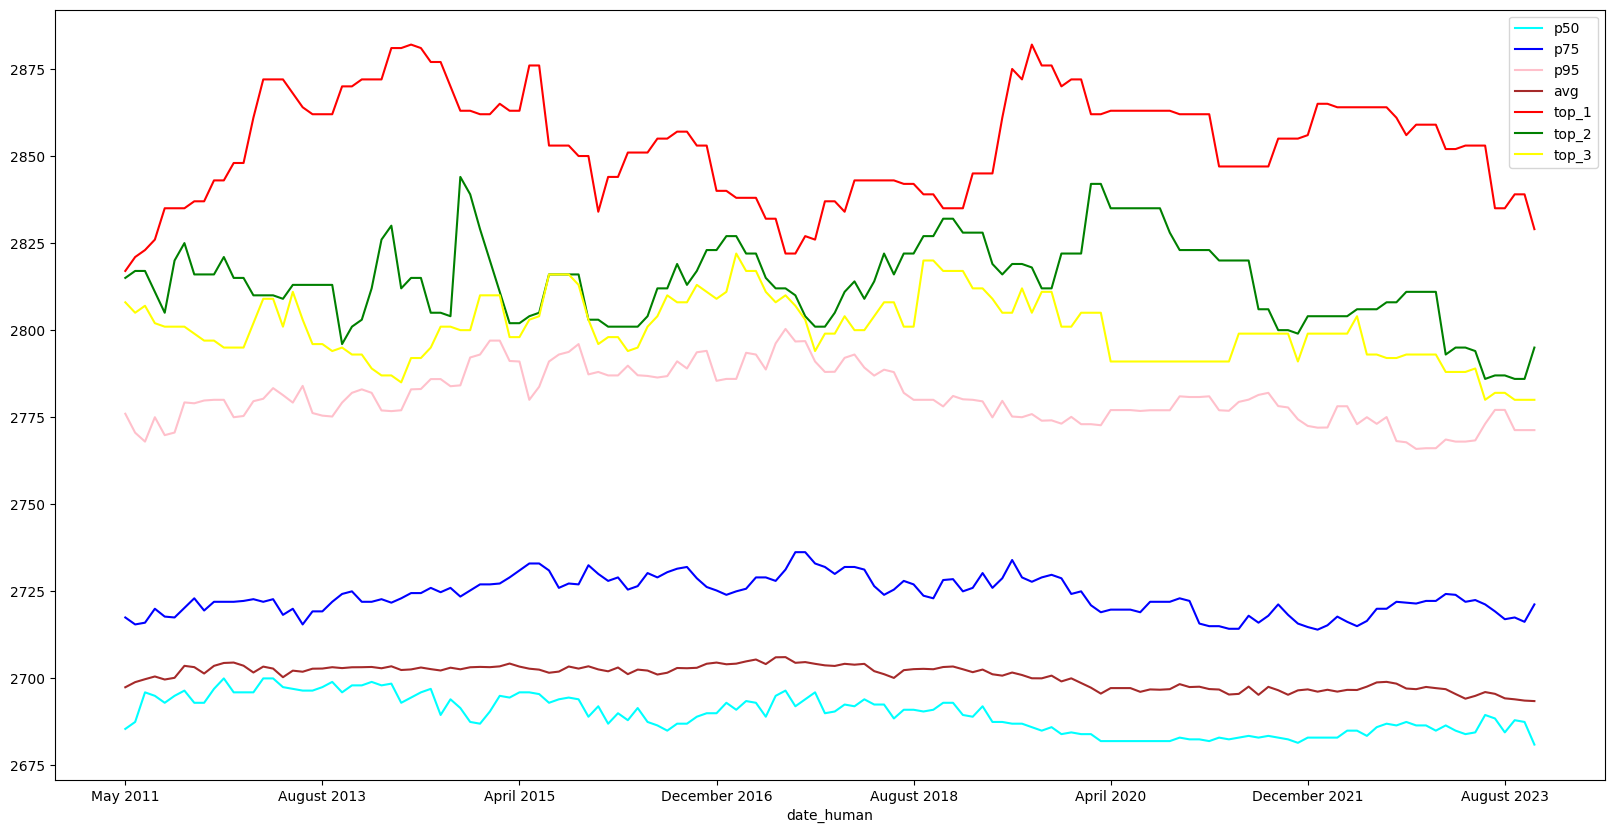

In [6]:
df = df[df.index >= magnus_vline_index]

ax = plt.gca()

for col_name in df.columns:
    if col_name == 'date_human':
        continue
    df.plot(kind='line', x='date_human', y=col_name, color=GRAPH_LINES_COLORS[col_name], ax=ax)

## Note

Carlsen is the top-1 player with large advantage over the top-2 since may-2011.

The fight for top-2 are very tough. There were moments when top-2 and top-3 were tied!

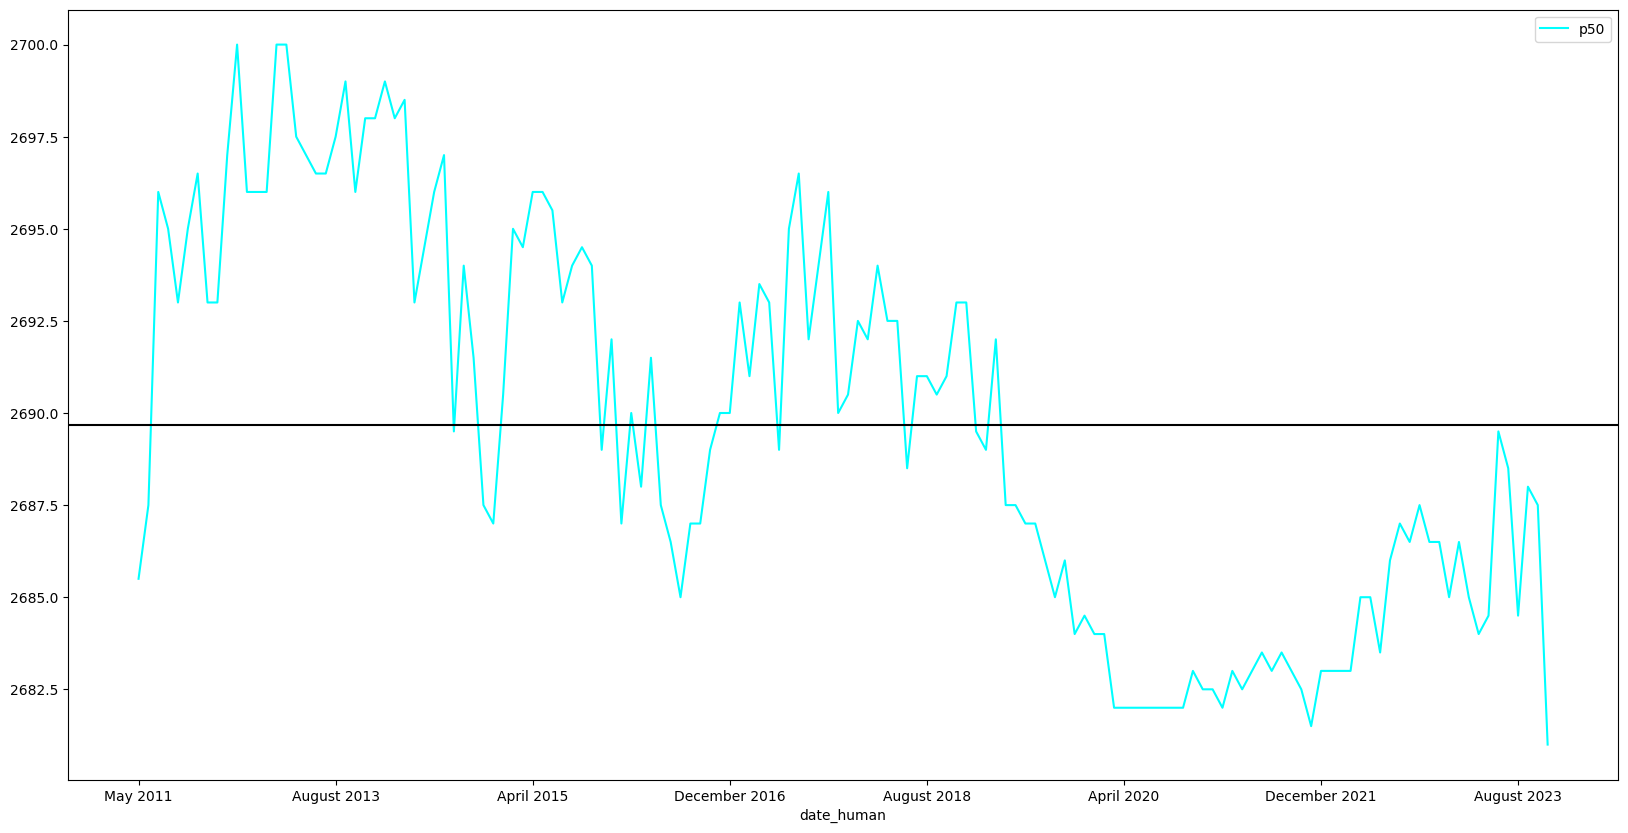

In [7]:
avg_p50 = np.average(df['p50'])

ax = plt.gca()
df.plot(kind='line', x='date_human', y='p50', color=GRAPH_LINES_COLORS['p50'], ax=ax)
plt.axhline(y=avg_p50, color='black', linestyle='-')
  
plt.show()

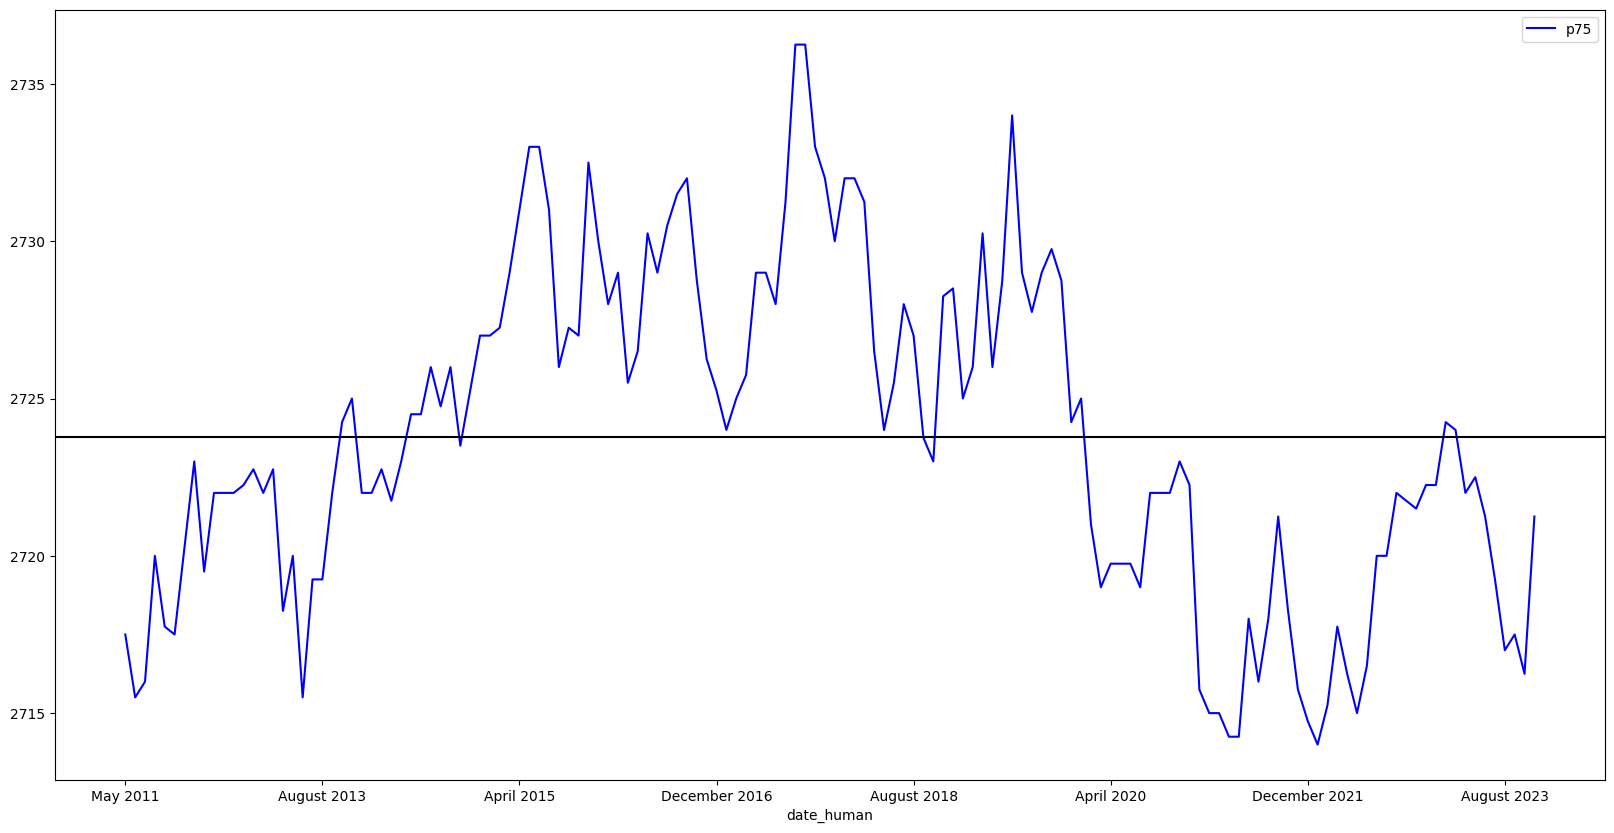

In [8]:
avg_p75 = np.average(df['p75'])

ax = plt.gca()
df.plot(kind='line', x='date_human', y='p75', color=GRAPH_LINES_COLORS['p75'], ax=ax)
plt.axhline(y=avg_p75, color='black', linestyle='-')
  
plt.show()

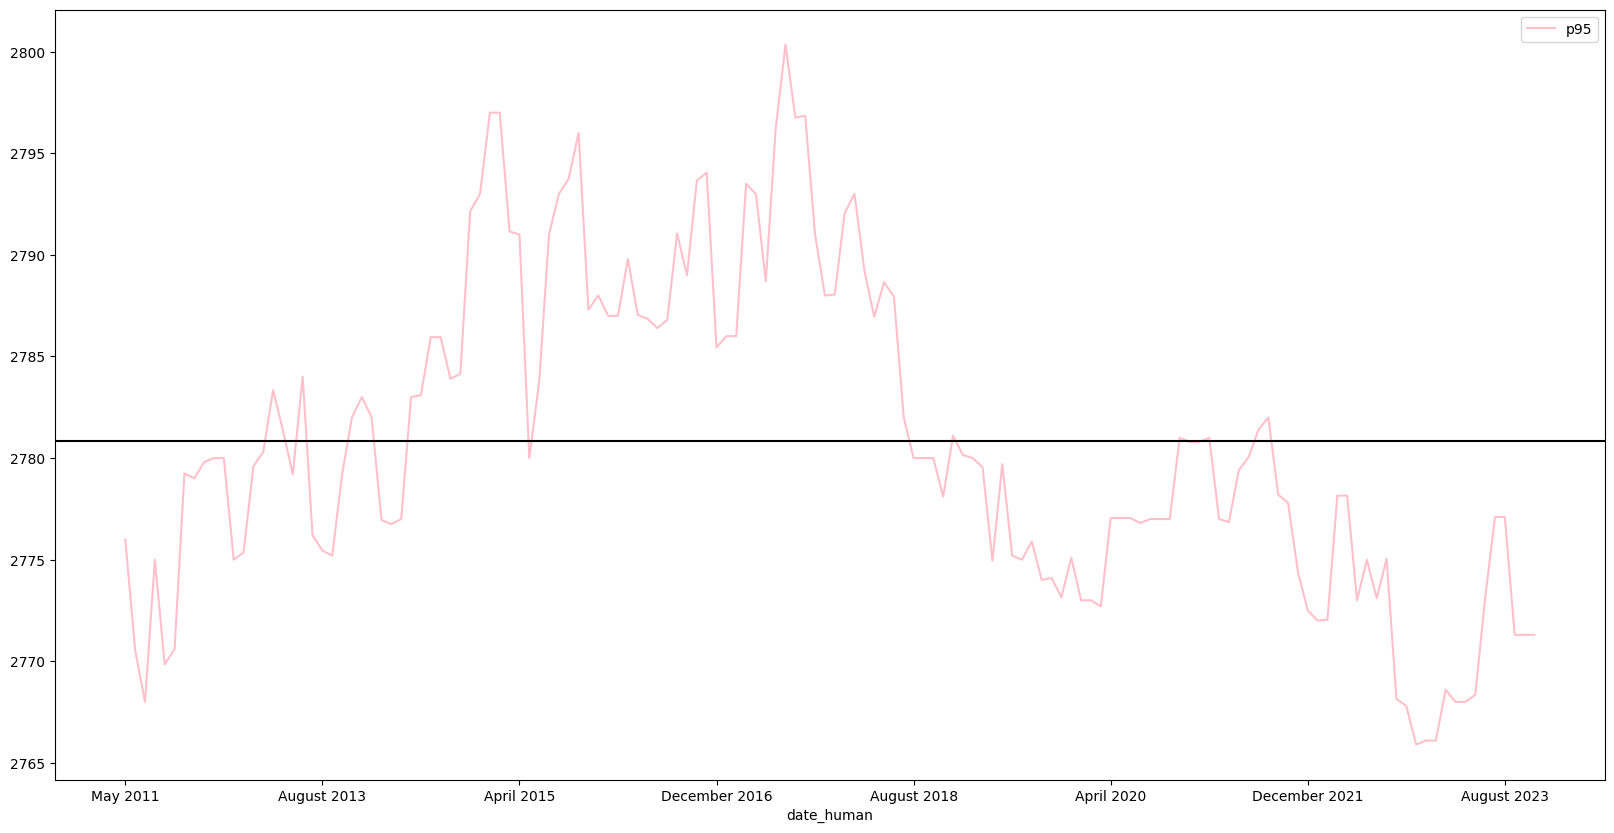

In [9]:
avg_p95 = np.average(df['p95'])

ax = plt.gca()
df.plot(kind='line', x='date_human', y='p95', color=GRAPH_LINES_COLORS['p95'], ax=ax)
plt.axhline(y=avg_p95, color='black', linestyle='-')
  
plt.show()

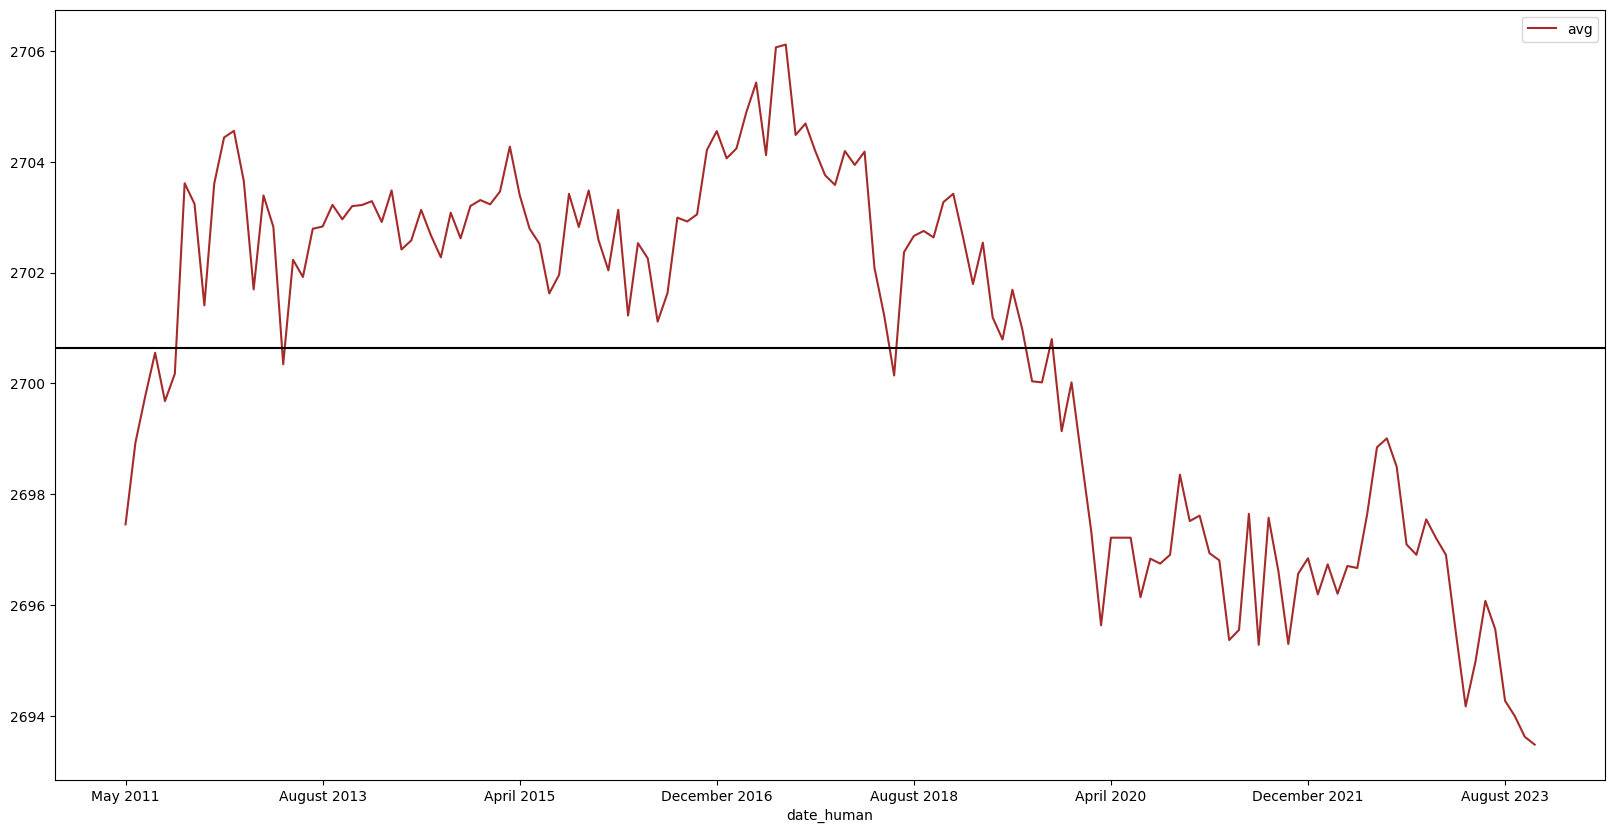

In [10]:
avg_avg = np.average(df['avg'])

ax = plt.gca()
df.plot(kind='line', x='date_human', y='avg', color=GRAPH_LINES_COLORS['avg'], ax=ax)
plt.axhline(y=avg_avg, color='black', linestyle='-')
  
plt.show()

## Note

The graphs above shows we're facing some kind of deflation in ratings since last months of 2018.

Now (november-2023), the percentiles and average rating of players are below its historical average.

# Ok... Looks like Magnus Carlsen is a outlier. Let's analyze again these metrics without him

In [11]:
data = []

for index, row in ratings_df.iterrows():
    all_ratings = [r[1] for r in row['ratings']][1:]
    all_ratings = np.array(all_ratings)

    top_2 = all_ratings[0]
    top_3 = all_ratings[1]

    data.append({
        'date_human': row['date_human'],
        'p50': np.percentile(all_ratings, 50),
        'p75': np.percentile(all_ratings, 75),
        'p95': np.percentile(all_ratings, 95),
        'avg': np.average(all_ratings),
        'top_2': top_2,
        'top_3': top_3,
    })

df_without_magnus = pd.DataFrame(data)
df_without_magnus = df_without_magnus[df_without_magnus.index >= magnus_vline_index]
df_without_magnus

,date_human,p50,p75,p95,avg,top_2,top_3
47,May 2011,2685.0,2716.50,2775.10,2696.252525,2815,2808
48,July 2011,2687.0,2715.00,2768.20,2697.696970,2817,2805
49,September 2011,2694.0,2716.00,2765.15,2698.540000,2817,2807
50,November 2011,2694.0,2716.25,2768.35,2699.300000,2811,2802
51,January 2012,2693.0,2715.50,2768.70,2698.368932,2805,2801
...,...,...,...,...,...,...,...
186,July 2023,2688.0,2719.00,2775.20,2694.161616,2787,2782
187,August 2023,2684.0,2713.50,2769.80,2692.858586,2787,2782
188,September 2023,2688.0,2716.50,2761.10,2692.535354,2786,2780
189,October 2023,2686.0,2716.00,2761.10,2692.161616,2786,2780


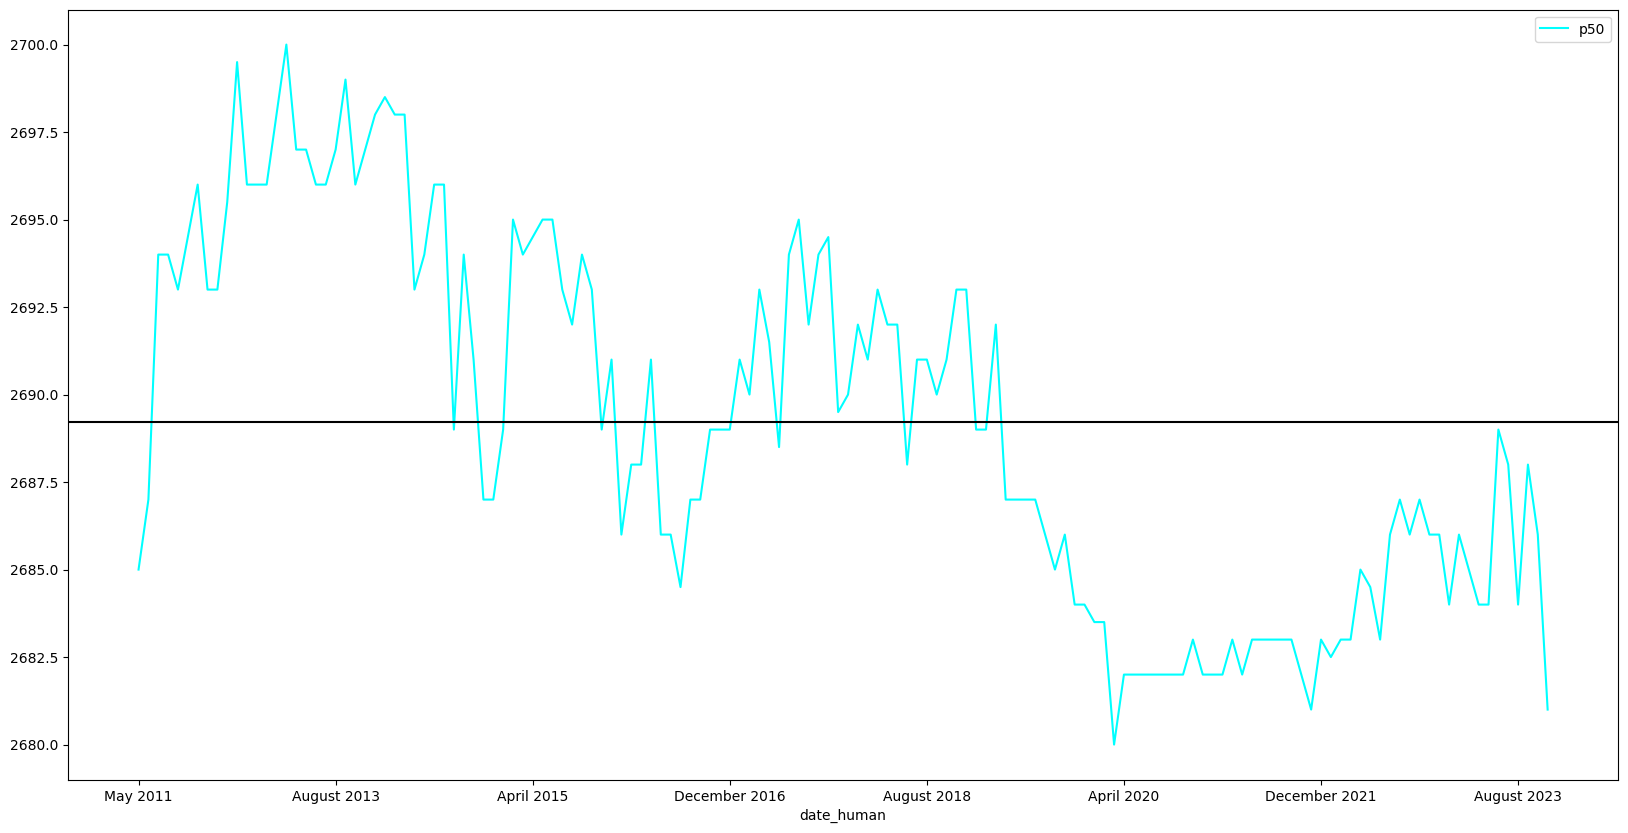

In [12]:
avg_p50 = np.average(df_without_magnus['p50'])

ax = plt.gca()
df_without_magnus.plot(kind='line', x='date_human', y='p50', color=GRAPH_LINES_COLORS['p50'], ax=ax)
plt.axhline(y=avg_p50, color='black', linestyle='-')
  
plt.show()

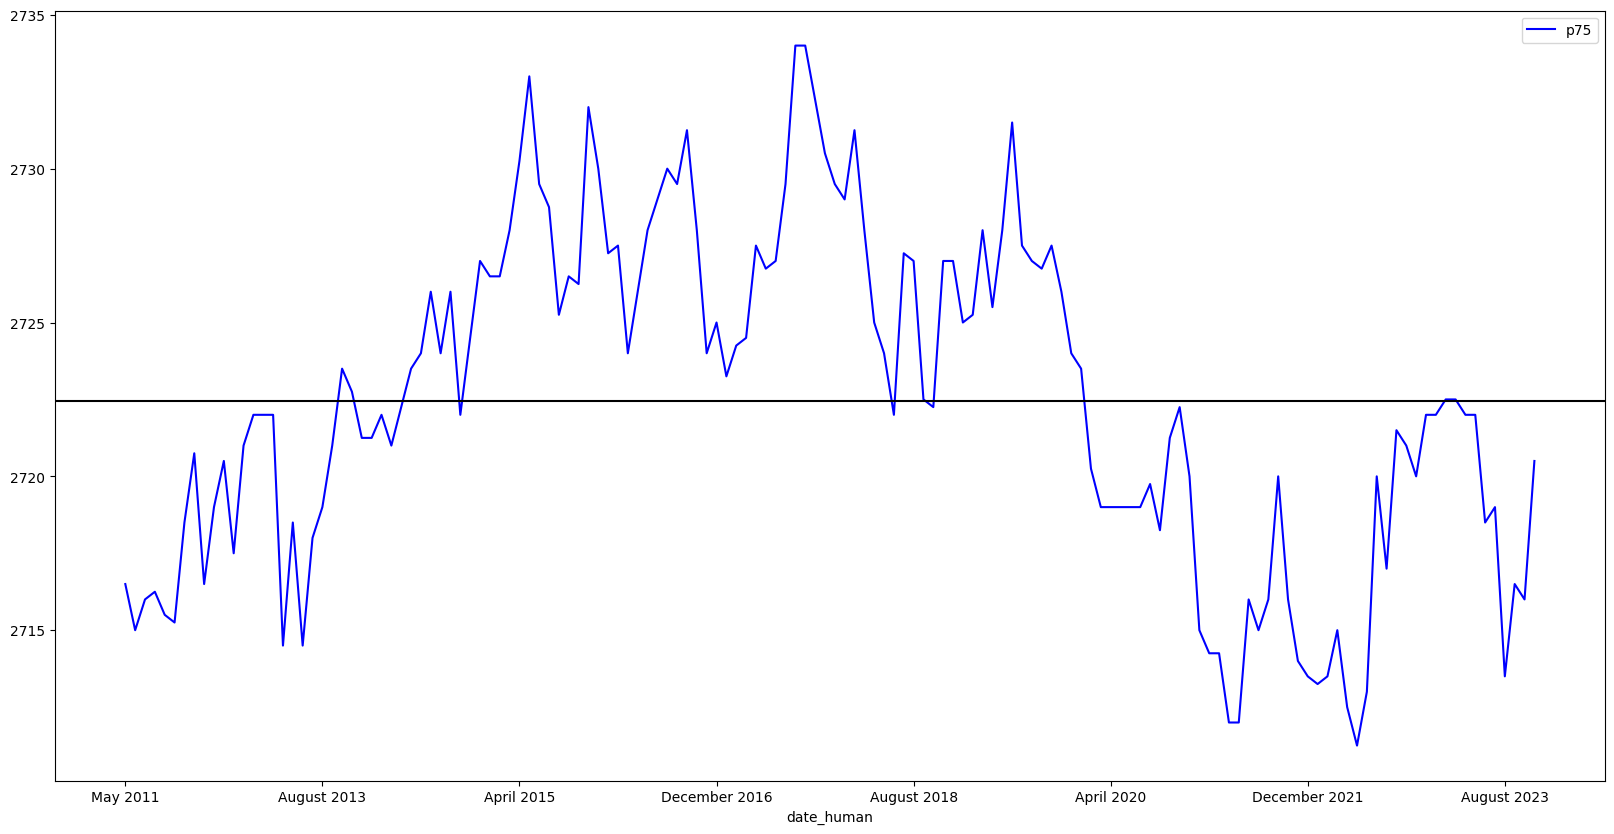

In [13]:
avg_p75 = np.average(df_without_magnus['p75'])

ax = plt.gca()
df_without_magnus.plot(kind='line', x='date_human', y='p75', color=GRAPH_LINES_COLORS['p75'], ax=ax)
plt.axhline(y=avg_p75, color='black', linestyle='-')
  
plt.show()

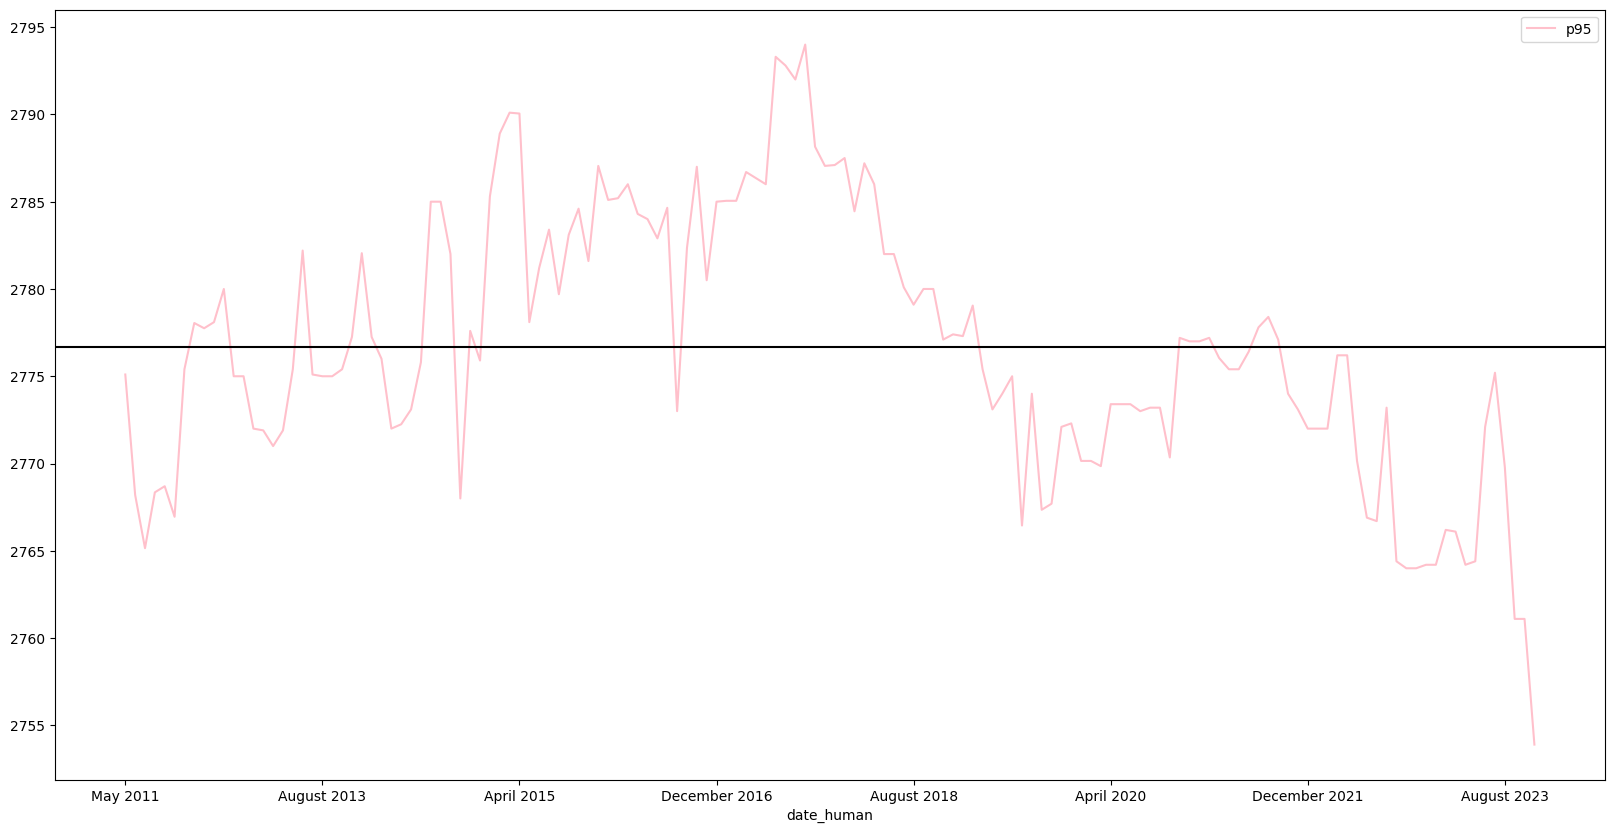

In [14]:
avg_p95 = np.average(df_without_magnus['p95'])

ax = plt.gca()
df_without_magnus.plot(kind='line', x='date_human', y='p95', color=GRAPH_LINES_COLORS['p95'], ax=ax)
plt.axhline(y=avg_p95, color='black', linestyle='-')
  
plt.show()

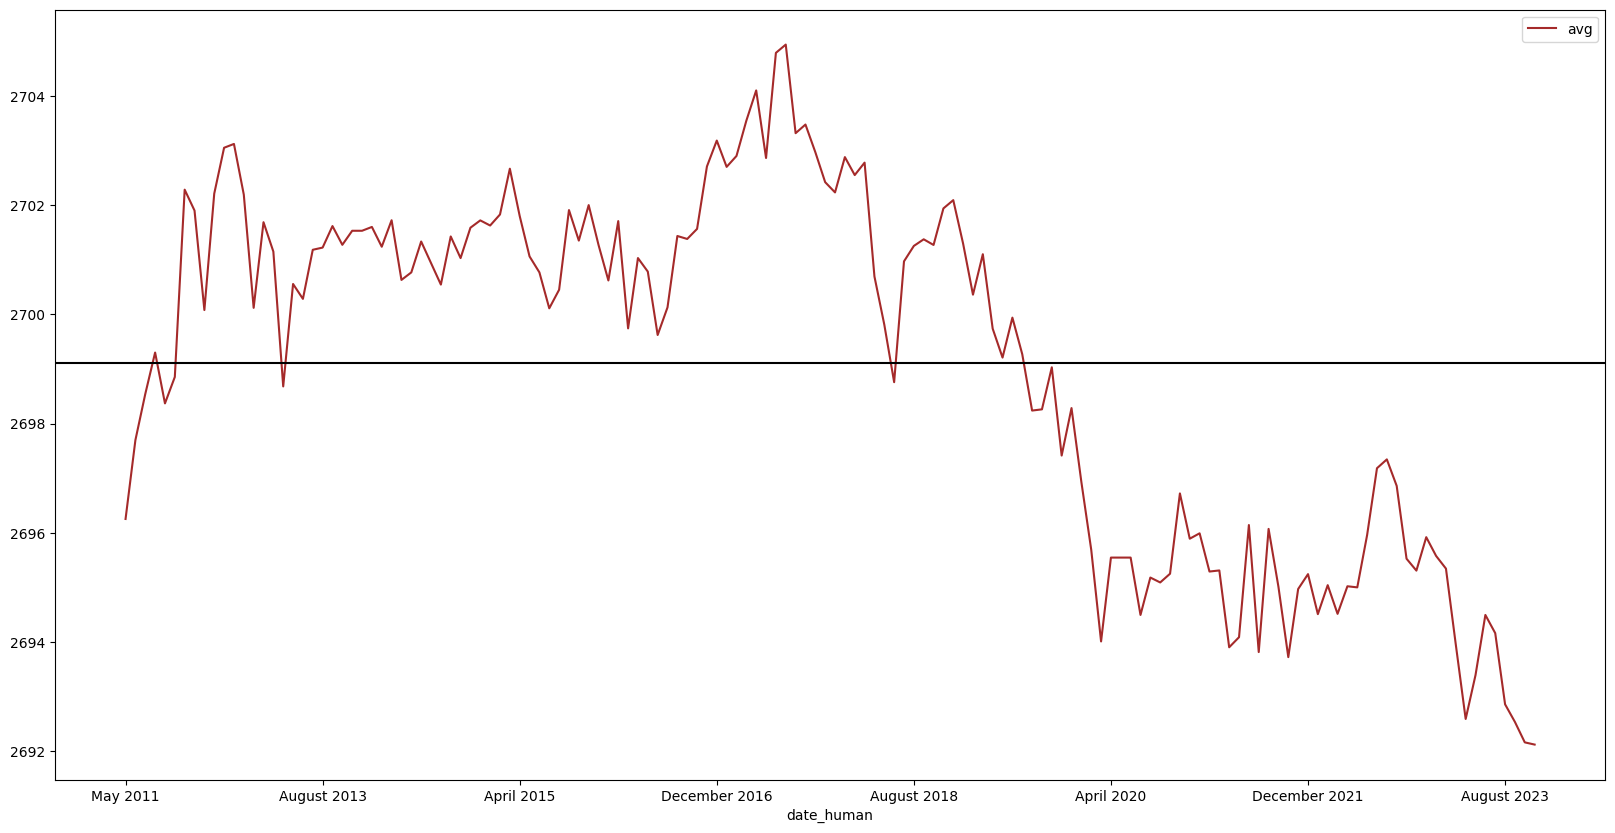

In [15]:
avg_avg = np.average(df_without_magnus['avg'])

ax = plt.gca()
df_without_magnus.plot(kind='line', x='date_human', y='avg', color=GRAPH_LINES_COLORS['avg'], ax=ax)
plt.axhline(y=avg_avg, color='black', linestyle='-')
  
plt.show()

## Note

Even if we disregard Magnus Carlsen when analyzing the percentiles and average of the top-100, we notice this small deflation in the rating.

# Is it fair to say "Magnus Carlsen is no longer the same"?

In [16]:
df['diff_top_1_2'] = df['top_1'] - df['top_2'] 
df

/var/folders/rc/y1hgn6zj2rv8xzfngv_2kjy80000gp/T/ipykernel_18885/2705333945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_top_1_2'] = df['top_1'] - df['top_2']


,date_human,p50,p75,p95,avg,top_1,top_2,top_3,diff_top_1_2
47,May 2011,2685.5,2717.50,2776.00,2697.460000,2817,2815,2808,2
48,July 2011,2687.5,2715.50,2770.55,2698.930000,2821,2817,2805,4
49,September 2011,2696.0,2716.00,2768.00,2699.772277,2823,2817,2807,6
50,November 2011,2695.0,2720.00,2775.00,2700.554455,2826,2811,2802,15
51,January 2012,2693.0,2717.75,2769.85,2699.682692,2835,2805,2801,30
...,...,...,...,...,...,...,...,...,...
186,July 2023,2688.5,2719.25,2777.10,2695.570000,2835,2787,2782,48
187,August 2023,2684.5,2717.00,2777.10,2694.280000,2835,2787,2782,48
188,September 2023,2688.0,2717.50,2771.30,2694.000000,2839,2786,2780,53
189,October 2023,2687.5,2716.25,2771.30,2693.630000,2839,2786,2780,53


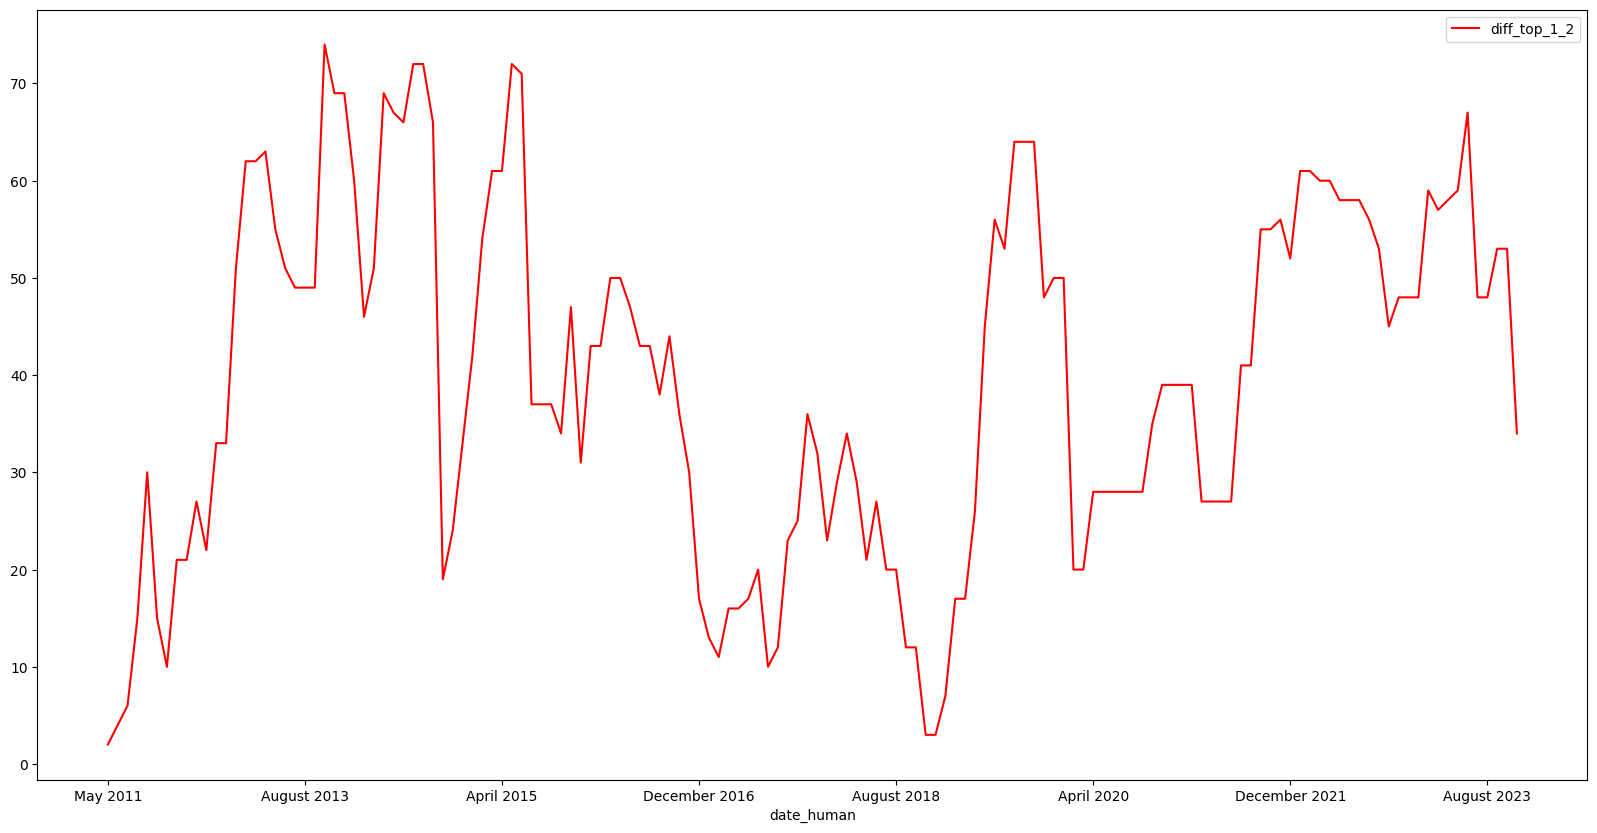

In [17]:
ax = plt.gca()
df.plot(kind='line', x='date_human', y='diff_top_1_2', color='red', ax=ax)
plt.show()

## Note

The graph above shows the difference over time between Magnus Carlsen and the top-2 player.

There were times when this distance was very small, but today (november-2023) it is at a very safe level (for Carlsen :))